In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr'

In [4]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=5, noise_scale=0.001, use_classes=list(range(0,10)))

In [5]:
print(timeseries.head)
# print(labels.head)
# print(test_timeseries.head)
# print(labels['label'])

<bound method NDFrame.head of                      Caf         h          Qf        Ca           T     Tf  \
node_id   timestamp                                                           
node_1_10 6          1.0  6.000047   99.997317  0.037232  402.346910  320.0   
          7          1.0  5.999947   99.998584  0.037218  402.354404  320.0   
          8          1.0  5.999883  100.000464  0.037229  402.355804  320.0   
          9          1.0  5.999891  100.002551  0.037235  402.356722  320.0   
          10         1.0  5.999971   99.998177  0.037222  402.357384  320.0   
...                  ...       ...         ...       ...         ...    ...   
node_9_99 95         1.0  5.999950  100.000000  0.053443  395.479570  320.0   
          96         1.0  5.999950  100.000000  0.053385  395.494621  320.0   
          97         1.0  5.999950  100.000000  0.053341  395.506833  320.0   
          98         1.0  5.999950  100.000000  0.053385  395.496690  320.0   
          99         1

In [6]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [7]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


[Pipeline] .......... (step 2 of 5) Processing features, total=   4.4s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [8]:
preds = pipeline.predict(test_timeseries)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


In [9]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.7928630390980599
0 0.7735537190082644
1 1.0
2 0.275
3 0.9927007299270073
4 0.9777777777777777
5 0.9852941176470589
6 0.9777777777777777
7 1.0
8 0.9927007299270073
9 0.0


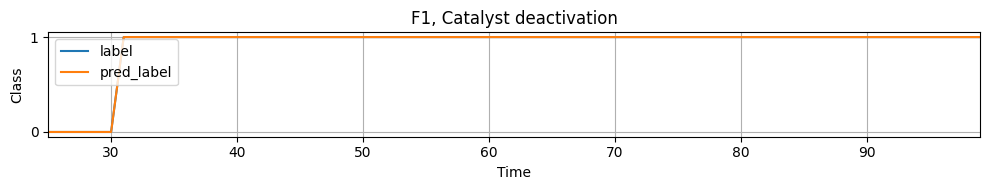

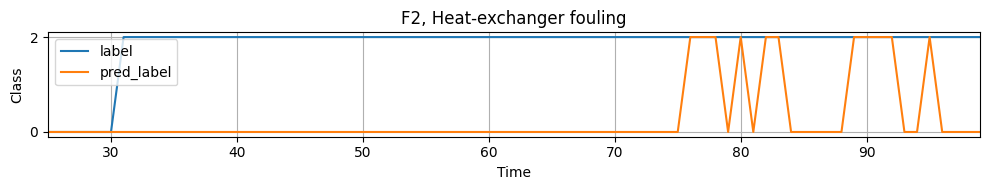

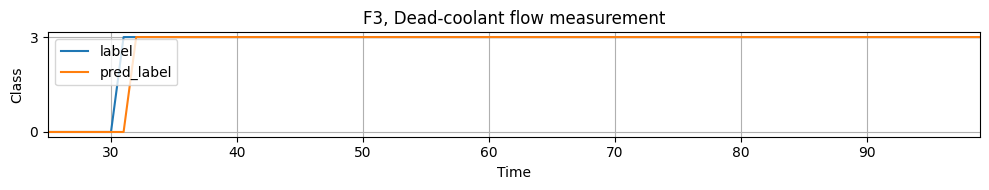

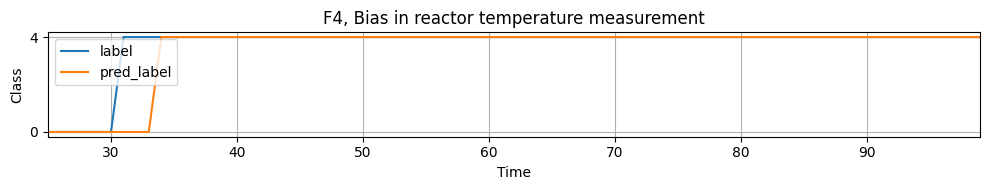

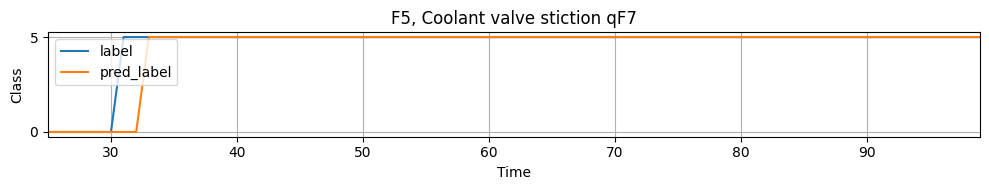

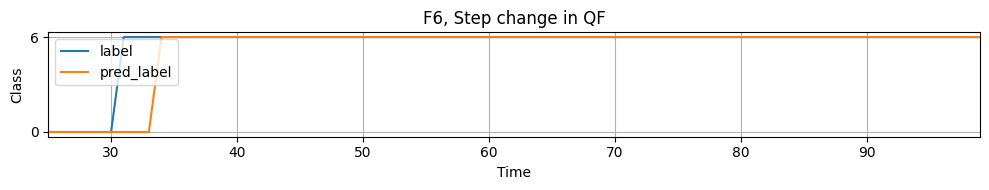

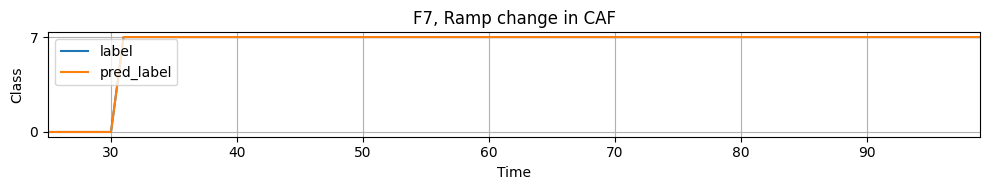

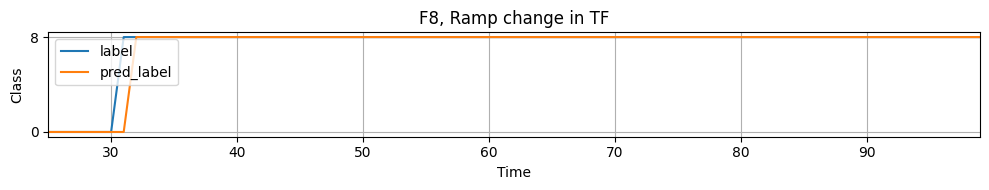

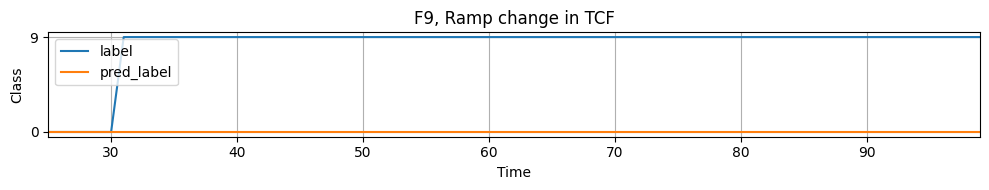

In [32]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,10):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))

    single_node_df.plot(figsize=(10, 2))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, i+1, step=i))
    # plt.xticks(np.arange(0, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[20], single_node_df.index[94])
    plt.tight_layout()
    plt.show()


In [19]:
# label_list = pipeline.steps[4][1].classes_
# cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
# for i in range(len(cf)):
#     cf[i] = [x / cf[i].sum() for x in cf[i]]    
# label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}
# # label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings'}

# text_labels = [label_dict[str(i)] for i in label_list]
# sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [20]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [21]:
test_labels['label']

node_id    timestamp
node_1_10  0            0
node_1_11  0            0
node_1_12  0            0
node_1_13  0            0
node_1_14  0            0
                       ..
node_9_95  0            9
node_9_96  0            9
node_9_97  0            9
node_9_98  0            9
node_9_99  0            9
Name: label, Length: 855, dtype: int64

In [33]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 9 #UPDATE HERE FOR OTHER CLASSES
pred_select = 0 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_9_31', 781], ['node_9_32', 782], ['node_9_33', 783], ['node_9_34', 784], ['node_9_35', 785], ['node_9_36', 786], ['node_9_37', 787], ['node_9_38', 788], ['node_9_39', 789], ['node_9_40', 790], ['node_9_41', 791], ['node_9_42', 792], ['node_9_43', 793], ['node_9_44', 794], ['node_9_45', 795], ['node_9_46', 796], ['node_9_47', 797], ['node_9_48', 798], ['node_9_49', 799], ['node_9_50', 801], ['node_9_51', 802], ['node_9_52', 803], ['node_9_53', 804], ['node_9_54', 805], ['node_9_55', 806], ['node_9_56', 807], ['node_9_57', 808], ['node_9_58', 809], ['node_9_59', 810], ['node_9_60', 812], ['node_9_61', 813], ['node_9_62', 814], ['node_9_63', 815], ['node_9_64', 816], ['node_9_65', 817], ['node_9_66', 818], ['node_9_67', 819], ['node_9_68', 820], ['node_9_69', 821], ['node_9_70', 823], ['node_9_71', 824], ['node_9_72', 825], ['node_9_73', 826], ['node_9_74', 827], ['node_9_75', 828], ['node_9_76', 829], ['node_9_77', 830], ['node_9_78', 831], ['node_9_79', 832], ['node_9_80', 834],

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-02-29 23:53:06,356 INFO    Working on turning label from 0 to 9


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-02-29 23:53:10,850 INFO    Finished constructing per class kdtree
2024-02-29 23:53:10,851 INFO    Returning distractors ['node_9_43', 'node_9_55']
2024-02-29 23:53:10,851 INFO    Trying distractor 1 / 2
/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be 

###########
['Tc', 'T', 'Q', 'h']
###########


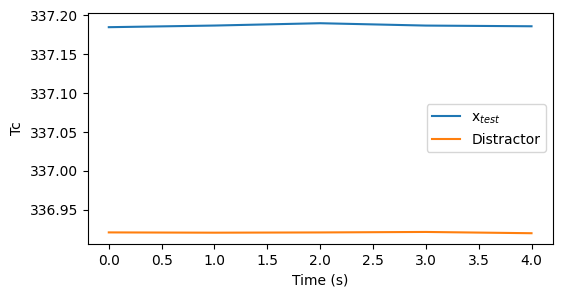

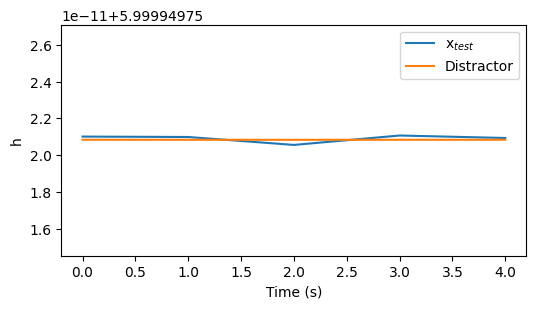

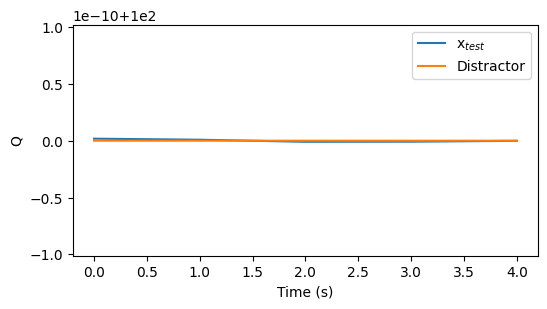

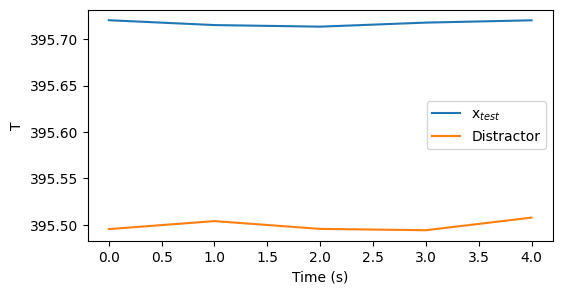

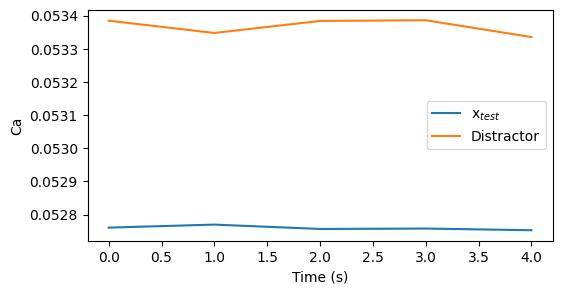

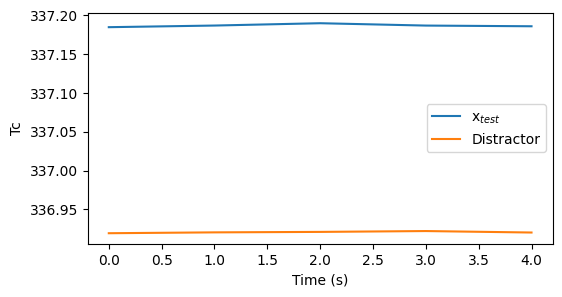

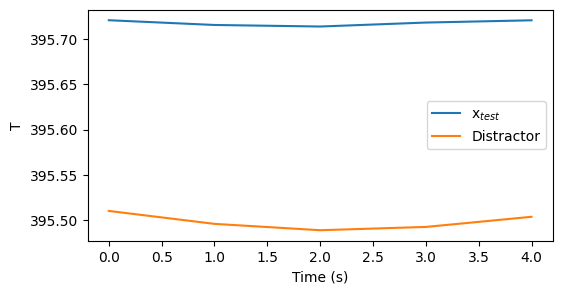

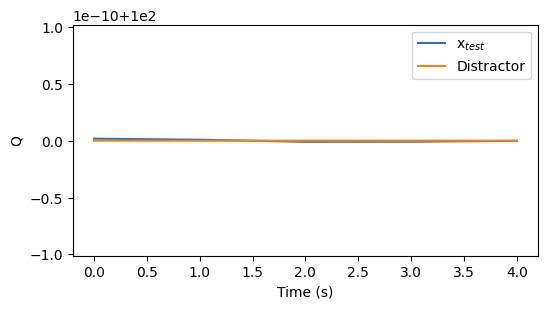

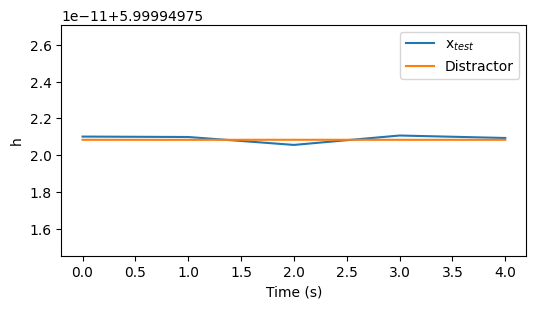

In [34]:
x_test = test_timeseries.loc[['node_9_53'], :, :]
explanation = comte.explain(x_test,to_maximize=true_select,savefig=False) 
print('###########') 
print(explanation)
print('###########')